In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as opt
from datasets import load_metric
from torch.utils.data import DataLoader, random_split
from tqdm.notebook import tqdm
import torchinfo

from utils import OCRTokenizer, OCRDataset, collate_batch, save_experiment_info

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

## Tokenizer & Dataset

In [3]:
tokenizer = OCRTokenizer('./synthetic_dataset/train/labels.txt')
tokenizer.counter.most_common(5)

[(' ', 10061), ('8', 3028), ('S', 3012), ('b', 3006), ('V', 2992)]

In [4]:
train_dataset = OCRDataset('./synthetic_dataset/train/', tokenizer, do_train_transform=True, image_size=(64, 256))  # need quadratic images for vit, 64 h for others
val_dataset = OCRDataset('./synthetic_dataset/val/', tokenizer, do_train_transform=False, image_size=(64, 256))
test_dataset = OCRDataset('./synthetic_dataset/test_clean/', tokenizer, do_train_transform=False, image_size=(64, 256))
test_captchas_dataset = OCRDataset('./synthetic_dataset/test_captchas/', tokenizer, do_train_transform=False, image_size=(64, 256))
len(train_dataset), len(val_dataset), len(test_dataset), len(test_captchas_dataset)

(20000, 1500, 5000, 5000)

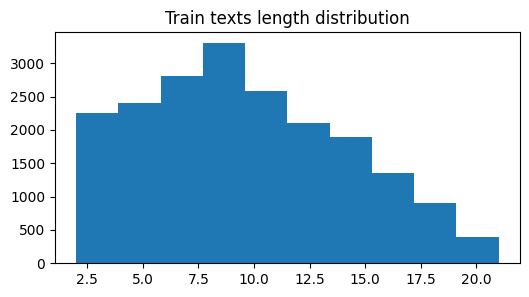

In [5]:
plt.figure(figsize=(6, 3))
plt.hist(np.array(list(map(lambda x: len(x[1]), train_dataset.data))))
plt.title('Train texts length distribution')
plt.show()

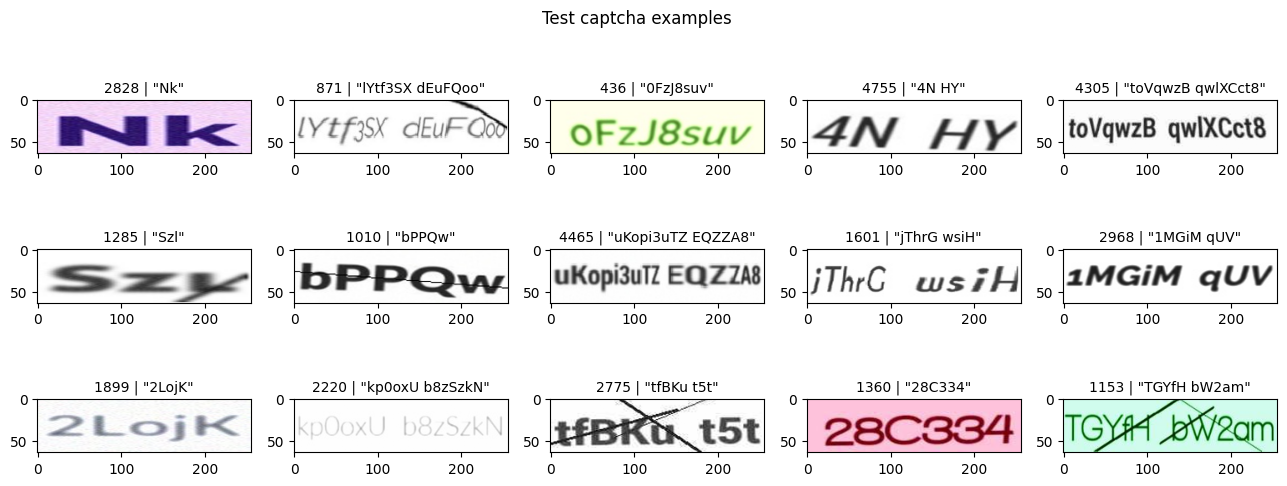

In [6]:
fig, axs = plt.subplots(3, 5, figsize=(16, 5.5))
for i in range(15):
    ax = axs[i // 5][i % 5]
    random_index = np.random.randint(0, len(test_captchas_dataset))
    ax.imshow(test_captchas_dataset.__getitem__(random_index)['image'].permute(1, 2, 0))
    ax.grid(False)
    text = "".join(tokenizer.decode(test_captchas_dataset[random_index]["labels"]))
    ax.set_title(f'{random_index} | "{text}"', fontsize=10)
fig.suptitle('Test captcha examples')
plt.show()

## Modeling

In [29]:
from transformers import ViTConfig
from modeling.encoders.cnn_bilstm import OCR_CRNN
from modeling.encoders.resnet_bilstm import OCR_ResNetRNN
from modeling.encoders.cnn_transformer import OCR_CNNBERT
from modeling.encoders.vit_bilstm import OCR_ViTRNN

In [30]:
# model = OCR_CNNBERT(vocab_size=len(tokenizer), hidden_dim=128,
#                     nhead=4, dim_feedforward=512, tr_layers=3, dropout=0.1).to(device).eval()
# model

In [31]:
# model = OCR_CRNN(vocab_size=len(tokenizer), hidden_dim=128, num_heads=2,
#                  lstm_layers=2, dropout=0.1).to(device).eval()
# model

In [32]:
model = OCR_ResNetRNN(resnet_model='resnet50', vocab_size=len(tokenizer), hidden_dim=256,
                      lstm_layers=2, dropout=0.1).to(device).eval()
model

OCR_ResNetRNN(
  (encoder): ResNetImageEncoder(
    (pre_bath_norm): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (model): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(2

In [33]:
# config = ViTConfig(hidden_size=128, num_hidden_layers=6,
#                    intermediate_size=512, patch_size=32, image_size=256, qkv_bias=False,
#                    attention_probs_dropout_prob=0.0, hidden_dropout_prob=0.1, num_attention_heads=2)
# model = OCR_ViTRNN(vit_config=config, vocab_size=len(tokenizer), lstm_layers=2, dropout=0.1).to(device).eval()
# model

In [34]:
torchinfo.summary(model)

Layer (type:depth-idx)                             Param #
OCR_ResNetRNN                                      --
├─ResNetImageEncoder: 1-1                          --
│    └─BatchNorm2d: 2-1                            6
│    └─Sequential: 2-2                             --
│    │    └─Conv2d: 3-1                            9,408
│    │    └─BatchNorm2d: 3-2                       128
│    │    └─ReLU: 3-3                              --
│    │    └─MaxPool2d: 3-4                         --
│    │    └─Sequential: 3-5                        215,808
│    │    └─Sequential: 3-6                        1,219,584
│    └─Sequential: 2-3                             --
│    │    └─ConvBlock: 3-7                         2,360,320
│    │    └─ConvBlock: 3-8                         2,360,320
│    │    └─ConvBlock: 3-9                         2,360,320
│    └─Dropout: 2-4                                --
│    └─Sequential: 2-5                             --
│    │    └─LayerNorm: 3-10              

In [35]:
model.encoder(torch.rand([2, 3, 64, 256]).to(device)).shape

torch.Size([2, 32, 256])

## Training

In [36]:
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, collate_fn=lambda x: collate_batch(x, tokenizer), num_workers=6)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False, collate_fn=lambda x: collate_batch(x, tokenizer), num_workers=6)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False, collate_fn=lambda x: collate_batch(x, tokenizer), num_workers=6)
test_captchas_loader = DataLoader(test_captchas_dataset, batch_size=512, shuffle=False, collate_fn=lambda x: collate_batch(x, tokenizer), num_workers=6)

In [37]:
num_epochs = 100
criterion = nn.CTCLoss(zero_infinity=True, blank=tokenizer.pad_token_id)
# criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
optimizer = opt.AdamW(model.parameters(), lr=5e-4)
wer_metric, cer_metric = load_metric('wer'), load_metric('cer')

In [38]:
def evaluate(model, data_loader, eval_er_scores = True):
    model.eval()
    losses, wer_scores, cer_scores = [], [], []
    for batch in data_loader:
        with torch.inference_mode():
            inputs, target_labels, target_lengths = batch['inputs'].to(device), batch['labels'].to(device), batch['lengths'].to(device)
            bs = inputs.shape[0]

            predictions = model(inputs)
            pridicted_labels = predictions.permute(1, 0, 2).argmax(-1)

            # CTCLoss
            input_lengths = torch.full(size=(bs,), fill_value=predictions.shape[0], dtype=torch.long)
            loss = criterion(predictions, target_labels, input_lengths, target_lengths)

            # CrossEntropy (needs same seq len in targets and predictions)
            # loss = criterion(predictions.permute(1, 0, 2).contiguous().view(-1, predictions.shape[-1]), target_labels.view(-1))

            # WER & CER
            if eval_er_scores:
                predicted_texts = tokenizer.decode_batch(pridicted_labels, drop_special=True, to_text=True)
                target_texts = tokenizer.decode_batch(target_labels, drop_special=True, to_text=True)
                wer_score = wer_metric.compute(predictions=predicted_texts, references=target_texts)
                cer_score = cer_metric.compute(predictions=predicted_texts, references=target_texts)

        losses.append(loss.detach().item())
        if eval_er_scores:
            wer_scores.append(wer_score)
            cer_scores.append(cer_score)

    if eval_er_scores:
        return np.mean(losses).round(5), np.mean(wer_scores).round(5), np.mean(cer_scores).round(5)
    else:
        return np.mean(losses).round(5), None, None

In [39]:
%%time
evaluate(model, val_loader, eval_er_scores=False)

CPU times: user 247 ms, sys: 327 ms, total: 573 ms
Wall time: 1.25 s


(17.16579, None, None)

In [40]:
%%time
evaluate(model, test_loader, eval_er_scores=False)

CPU times: user 708 ms, sys: 489 ms, total: 1.2 s
Wall time: 1.94 s


(17.03325, None, None)

In [41]:
def train(model, checkpoints_dir):
    Path(checkpoints_dir).mkdir(parents=True, exist_ok=True)
    losses_history = {
        'train': [],
        'eval': []
    }
    min_eval_loss = 999999999.9

    for epoch in tqdm(range(num_epochs)):
        model.train()
        print(f'---------- | Epoch: {epoch} | ----------')
        train_losses = []

        for batch in train_loader:
            inputs, target_labels, target_lengths = batch['inputs'].to(device), batch['labels'].to(device), batch['lengths'].to(device)

            predictions = model(inputs)
            input_lengths = torch.full(size=(inputs.shape[0],), fill_value=predictions.shape[0], dtype=torch.long)
            loss = criterion(predictions, target_labels, input_lengths, target_lengths)

            loss.backward()

            train_losses.append(loss.item())

            optimizer.step()
            optimizer.zero_grad()

            # progress_bar.update(1)
        train_loss = np.array(train_losses).mean()
        eval_scores = evaluate(model, val_loader, eval_er_scores=(epoch % 3 == 0 and epoch > 14))

        losses_history['train'].append(train_loss)
        losses_history['eval'].append(eval_scores[0])

        print(f'[TRAIN] Mean epoch loss: {train_loss}')
        print(f'[EVAL] Mean epoch loss: {eval_scores[0]}, WER: {eval_scores[1]}, CER: {eval_scores[2]}')

        if eval_scores[0] < min_eval_loss:
            print(f'Current best on eval, saving model to {checkpoints_dir}...')
            torch.save(model, checkpoints_dir + 'best_model.pth')
            tokenizer.save_to(checkpoints_dir + 'tokenizer.pickle')
            min_eval_loss = eval_scores[0]

        save_experiment_info(model, losses_history, checkpoints_dir + 'experiment_info.json')

    return losses_history

In [42]:
history = train(model, checkpoints_dir='./experiments/resnet50_256_lstm_2l_100e/')

  0%|          | 0/100 [00:00<?, ?it/s]

---------- | Epoch: 0 | ----------
[TRAIN] Mean epoch loss: 5.263433728037001
[EVAL] Mean epoch loss: 4.49665, WER: None, CER: None
Current best on eval, saving model to ./experiments/resnet50_256_lstm_2l_100e/...
---------- | Epoch: 1 | ----------
[TRAIN] Mean epoch loss: 4.396957928621316
[EVAL] Mean epoch loss: 4.38662, WER: None, CER: None
Current best on eval, saving model to ./experiments/resnet50_256_lstm_2l_100e/...
---------- | Epoch: 2 | ----------
[TRAIN] Mean epoch loss: 4.372395207610311
[EVAL] Mean epoch loss: 4.373, WER: None, CER: None
Current best on eval, saving model to ./experiments/resnet50_256_lstm_2l_100e/...
---------- | Epoch: 3 | ----------
[TRAIN] Mean epoch loss: 4.33993940111957
[EVAL] Mean epoch loss: 4.32296, WER: None, CER: None
Current best on eval, saving model to ./experiments/resnet50_256_lstm_2l_100e/...
---------- | Epoch: 4 | ----------
[TRAIN] Mean epoch loss: 4.260824185383471
[EVAL] Mean epoch loss: 4.24605, WER: None, CER: None
Current best on

[TRAIN] Mean epoch loss: 0.13045391468684883
[EVAL] Mean epoch loss: 0.17576, WER: 0.30567, CER: 0.07841
---------- | Epoch: 43 | ----------
[TRAIN] Mean epoch loss: 0.1404832470454747
[EVAL] Mean epoch loss: 0.18698, WER: None, CER: None
---------- | Epoch: 44 | ----------
[TRAIN] Mean epoch loss: 0.15226419185158574
[EVAL] Mean epoch loss: 0.18114, WER: None, CER: None
---------- | Epoch: 45 | ----------
[TRAIN] Mean epoch loss: 0.12791305799272995
[EVAL] Mean epoch loss: 0.17322, WER: 0.29008, CER: 0.07467
---------- | Epoch: 46 | ----------
[TRAIN] Mean epoch loss: 0.12619526835182046
[EVAL] Mean epoch loss: 0.17706, WER: None, CER: None
---------- | Epoch: 47 | ----------
[TRAIN] Mean epoch loss: 0.13020242099897772
[EVAL] Mean epoch loss: 0.17887, WER: None, CER: None
---------- | Epoch: 48 | ----------
[TRAIN] Mean epoch loss: 0.1199713985942587
[EVAL] Mean epoch loss: 0.17224, WER: 0.30638, CER: 0.07902
Current best on eval, saving model to ./experiments/resnet50_256_lstm_2l_10

[TRAIN] Mean epoch loss: 0.08126811155035527
[EVAL] Mean epoch loss: 0.17087, WER: None, CER: None
---------- | Epoch: 99 | ----------
[TRAIN] Mean epoch loss: 0.07844826140547101
[EVAL] Mean epoch loss: 0.15048, WER: 0.30393, CER: 0.07389


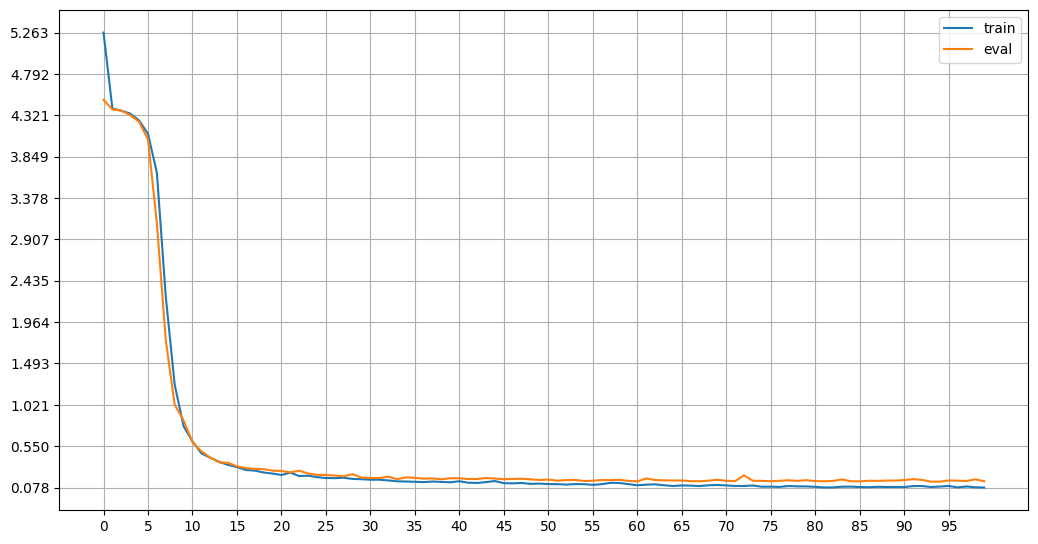

In [43]:
fig = plt.gcf()
fig.set_size_inches(12.5, 6.5)
plt.plot(history['train'], label = 'train')
plt.plot(history['eval'], label = 'eval')
plt.yticks(np.linspace(min(history['train']), max(history['train']), 12))
plt.xticks(range(0, len(history['train']), 5))
plt.grid()
plt.legend()
plt.show()

## Manual testing

In [44]:
!ls -lh ./experiments

total 32K
drwxrwxr-x 2 hivaze hivaze 4.0K Apr  5 15:57 cnn_v2_128_64seq_alstm_1h_2l_100e
drwxrwxr-x 2 hivaze hivaze 4.0K Apr  5 19:12 cnn_v2_128_64seq_bert_4h_3l_100e
drwxrwxr-x 2 hivaze hivaze 4.0K Apr  5 14:57 cnn_v2_128_64seq_lstm_2l_100e
drwxrwxr-x 2 hivaze hivaze 4.0K Apr  5 16:44 cnn_v2_128_64seq_lstma_2h_2l_100e
drwxrwxr-x 2 hivaze hivaze 4.0K Apr  5 17:49 cnn_v2_128_64seq_lstma_2h_2l_150e
drwxrwxr-x 2 hivaze hivaze 4.0K Apr  6 00:13 resnet18_128_lstm_2l_100e
drwxrwxr-x 2 hivaze hivaze 4.0K Apr  6 00:58 resnet34_128_lstm_2l_100e
drwxrwxr-x 2 hivaze hivaze 4.0K Apr  6 01:45 resnet50_256_lstm_2l_100e


In [45]:
best_model = torch.load('./experiments/resnet50_256_lstm_2l_100e/best_model.pth').eval()

In [50]:
evaluate(best_model, test_loader)

(0.09287, 0.24386, 0.05388)

In [53]:
evaluate(best_model, test_captchas_loader)

(0.13561, 0.29682, 0.07257)

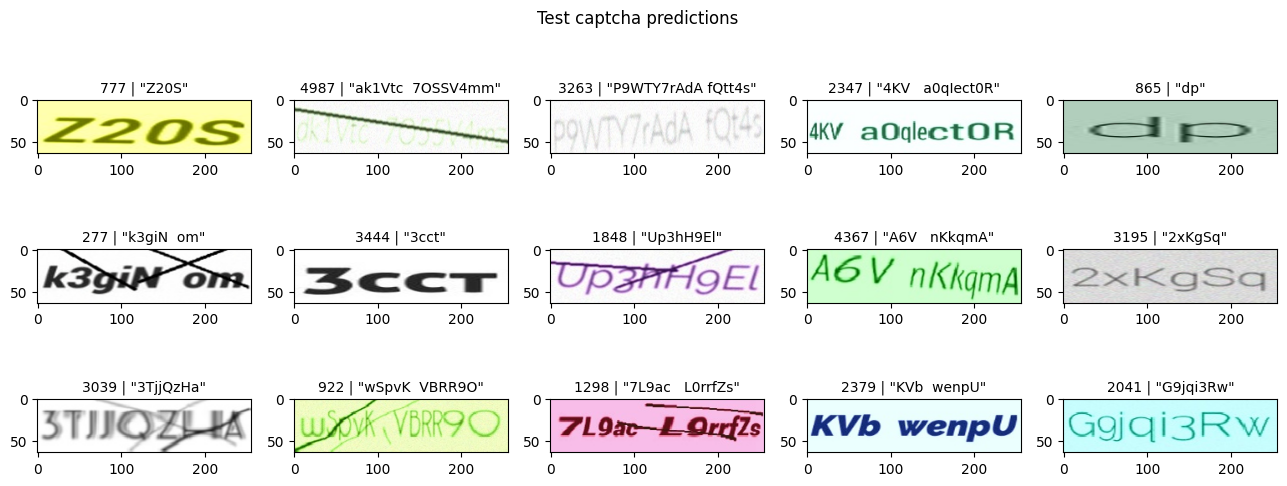

In [48]:
fig, axs = plt.subplots(3, 5, figsize=(16, 5.5))
for i in range(15):
    ax = axs[i // 5][i % 5]
    random_index = np.random.randint(0, len(test_captchas_dataset))
    test_image = test_captchas_dataset.__getitem__(random_index)['image']
    ax.imshow(test_image.permute(1, 2, 0))
    ax.grid(False)
    predictions = best_model(test_image.unsqueeze(0).to(device)).permute(1, 0, 2).argmax(-1)
    text = tokenizer.decode(predictions, drop_special=True, to_text=True)
    ax.set_title(f'{random_index} | "{text}"', fontsize=10)
fig.suptitle('Test captcha predictions')
plt.show()